## Imports

In [1]:
import os
# Set CUDA_VISIBLE_DEVICES before importing torch so the chosen physical GPU is exposed correctly.
# Use the physical GPU index reported by `nvidia-smi` (e.g. "1" for the second card).

# Now import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
# import holoviews as hv
import tifffile
import careamics
from careamics import CAREamist
from careamics.utils.metrics import scale_invariant_psnr, psnr, avg_range_invariant_psnr
import ramanspy as rpT
import pandas
from typing import List
import xarray as xa
import platform
import subprocess
import sys
sys.path.append('../RamaN2V/')  # for plot_utils.py
from plot_utils import compare_spectra, SpectralData
import plot_utils as pu
# Diagnostics: confirm available physical GPUs (nvidia-smi) and what PyTorch sees.
# This verifies mapping between physical index (nvidia-smi) and PyTorch visible index.
try:
    smi = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=index,name,memory.total", "--format=csv,noheader"],
        stderr=subprocess.STDOUT
    ).decode().strip()
except Exception:
    smi = "nvidia-smi not available or failed"
print("nvidia-smi GPUs (physical index, name, memory):\n", smi)
print(f"CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"Python platform: {platform.platform()}")
print(f"PyTorch version: {torch.__version__}")

# After setting CUDA_VISIBLE_DEVICES='1', physical GPU 1 will appear as cuda:0 to PyTorch.
if torch.cuda.is_available():
    print(f"PyTorch sees {torch.cuda.device_count()} CUDA device(s)")
    device = torch.device("cuda:0")          # use cuda:0 because only the selected physical GPU is visible
    torch.cuda.set_device(0)                 # set default device index within the visible devices
    print(f"Using PyTorch device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif torch.backends.mps.is_available():
    print("PyTorch sees an Apple Silicon GPU (MPS backend).")
    device = torch.device("mps")
    print(f"Using PyTorch device: {device}")
else:
    print("No CUDA GPUs available to PyTorch (torch.cuda.is_available() == False).")
    print("If you expect GPUs, restart the kernel after changing CUDA_VISIBLE_DEVICES, or launch Jupyter with the env var set:")
    print("  CUDA_VISIBLE_DEVICES=1 jupyter lab  # or jupyter notebook")
    print("Ensure NVIDIA drivers and CUDA are installed and compatible with torch build.")
print(os.getcwd())

# %matplotlib widget
%load_ext autoreload
%autoreload 2

nvidia-smi GPUs (physical index, name, memory):
 nvidia-smi not available or failed
CUDA_VISIBLE_DEVICES=None
Python platform: macOS-26.2-arm64-arm-64bit-Mach-O
PyTorch version: 2.8.0
PyTorch sees an Apple Silicon GPU (MPS backend).
Using PyTorch device: mps
/Users/tom/Developments/Raman/flogen


### Load Fluorophores from CSV

In [2]:
from fluorophore_loader import load_fluorophores
from flogen import SyntheticConfig, SyntheticBleachingDataset
import importlib

# Load real fluorophores
fluorophore_ds = load_fluorophores(
    'uniform.csv',
    laser_nm=532.0,
    crop_range=(500, 1700),
  )
fluorophore_ds



<xarray.Dataset> Size: 9kB
Dimensions:           (sample: 22, wavenumber: 38)
Coordinates:
  * sample            (sample) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * wavenumber        (wavenumber) float64 304B 515.5 548.8 ... 1.674e+03
Data variables:
    intensity         (sample, wavenumber) float64 7kB 0.5219 0.5027 ... 0.0916
    fluorophore_name  (sample) <U17 1kB 'Citrine em' 'DsRed em' ... 'dsFP483 em'
Attributes:
    source:       uniform.csv
    laser_nm:     532.0
    axis_units:   cm⁻¹
    description:  Fluorophore emission spectra from fpbase.org/fluorophores.org

### Visualise Loaded Fluorophores

In [3]:
fluorophore_ds.wavenumber.values

array([ 515.45683221,  548.81729872,  582.05623348,  615.17429938,
        648.17215452,  681.05045222,  713.80984106,  746.45096496,
        778.97446318,  811.38097041,  843.67111675,  875.8455278 ,
        907.90482467,  939.84962406,  971.68053824, 1003.39817515,
       1035.0031384 , 1066.4960273 , 1097.87743696, 1129.14795823,
       1160.30817785, 1191.35867839, 1222.30003832, 1253.13283208,
       1283.85763006, 1314.47499869, 1344.9855004 , 1375.38969375,
       1405.68813338, 1435.88137009, 1465.96995087, 1495.95441892,
       1525.83531367, 1555.61317086, 1585.28852251, 1614.86189701,
       1644.33381911, 1673.70480997])

(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

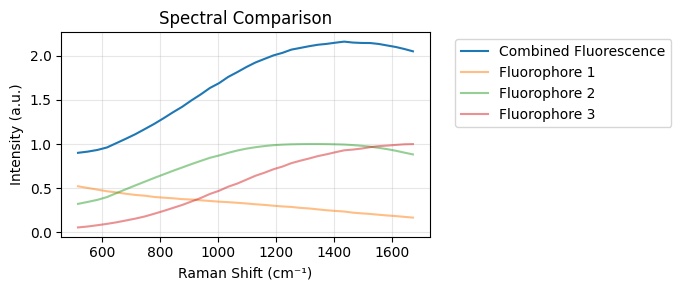

In [3]:
combined_fluorescence = pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=[0,1,2]).sum(dim="sample")['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)
fluorophore_ds_spectra = pu.convert_to_spectral_data(data=fluorophore_ds['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)
pu.compare_spectra(
    [combined_fluorescence, pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=0)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)  , pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=1)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values), pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=2)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)],
    titles=["Combined Fluorescence", "Fluorophore 1", "Fluorophore 2", "Fluorophore 3"],
    n_samples=3,
    height=3,
    alphas=[1.0, 0.5, 0.5, 0.5],
    width=7,
)

In [ ]:
pu.compare_spectra(

### Create Bleaching Dataset Using Loaded Fluorophores

In [4]:
import sys
from ATCCLoader import load_data

sys.path.append("../RamaN2V/")  # for plot_utils.py

atcc_dataset = load_data("../RamaN2V/data/ATCC/")

# Preprocess as desired
atcc_xr = atcc_dataset.to_xarray(
    crop=(500, 1700),
    remove_outliers=True,
    remove_incomplete=True,
    despike=True,
)

# # Generate synthetic bleaching data
config = SyntheticConfig(
    n_samples=1000,
    bleaching_interval=0.1,
    bleaching_max_time=10.0,
    integration_times=["15s"],
    decay_rate_min=0.3,
    decay_rate_max=5,
    poisson_noise_scale=2,
    gaussian_noise_scale=0.2,
    fr_ratio_min=7.0,
    fr_ratio_max=12.0,
    noise_type="poisson_gaussian",
    abundance_min=0.1,
    abundance_max=20,
    interpolation_method="polynomial",
)


# config = SyntheticConfig(
#     n_samples=1000,
#     n_fluorophores=3,
#     decay_rate_min=0.4,
#     decay_rate_max=1.5,
#     fluorophore_variation=0.1,  # 10% variation
# )

# Generate with real fluorophores
generator = SyntheticBleachingDataset(
    config,
    atcc_xr,
    fluorophore_xr=fluorophore_ds,  # Pass real spectra
)
synthetic_ds = generator.generate()

# generator.save("synthetic_bleaching_10k.nc")

Found 11250 spectrum files
  -> New calibration set detected! (Set #0)
  -> New calibration set detected! (Set #1)
  -> New calibration set detected! (Set #2)

Successfully loaded 11250 spectra

Loaded 9 strains:
  Strain 12228 (Staphylococcus epidermidis, G+): 1250 spectra
  Strain 19606 (Acinetobacter baumannii, G-): 1250 spectra
  Strain 25922 (Escherichia coli, G-): 1250 spectra
  Strain 25923 (Staphylococcus aureus, G+): 1250 spectra
  Strain 27853 (Pseudomonas aeruginosa, G-): 1250 spectra
  Strain 29212 (Enterococcus faecalis, G+): 1250 spectra
  Strain 29213 (Staphylococcus aureus, G+): 1250 spectra
  Strain 35218 (Escherichia coli, G-): 1250 spectra
  Strain 700603 (Klebsiella Pneumoniae, G-): 1250 spectra

=== Outlier Removal Summary ===
Strain 12228: Orig: 375, Rm: 4 (Sat: 1, Drop: 3)
Strain 19606: Orig: 250, Rm: 7 (Sat: 0, Drop: 7)
Strain 25922: Orig: 250, Rm: 6 (Sat: 0, Drop: 6)
Strain 25923: Orig: 250, Rm: 7 (Sat: 2, Drop: 5)
Strain 27853: Orig: 250, Rm: 4 (Sat: 0, Drop: 

In [19]:
config = SyntheticConfig(
    n_samples=1000,
    bleaching_interval=0.1,
    bleaching_max_time=10.0,
    integration_times=["10s"],
    decay_rate_min=0.01,
    decay_rate_max=3,
    poisson_noise_scale=1.2,
    gaussian_noise_scale=0.05,
    fr_ratio_min=11.0,
    fr_ratio_max=12.0,
    noise_type="poisson_gaussian",
    abundance_min=0.5,
    abundance_max=2.0,
    interpolation_method="polynomial",
    fluorophore_variation=0.0,
    seed=None,
)
generator = SyntheticBleachingDataset(
    config,
    atcc_xr,
    fluorophore_xr=fluorophore_ds,  # Pass real spectra
)
synthetic_ds = generator.generate()

Bleaching time points: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]

Using integration time '10s' for Raman extraction
Available samples: 1830
Wavenumber axes shape: (1830, 630)
Wavenumber axis: per-sample (calibration drift preserved) with shape (1830, 630)
Sampling real fluorophore spectra for bases...
  Fluorophore wavenumber axis found with shape (38,)

Generating 1000 synthetic samples...
  Generated 500/1000
  Generated 1000/1000

Generated dataset:
  Samples: 1000
  Bleaching time points: 101
  Wavenumber axis: per-sam

In [127]:
synthetic_ds

<xarray.Dataset> Size: 514MB
Dimensions:               (sample: 1000, bleaching_time: 101, wavenumber: 630,
                           fluorophore: 3)
Coordinates:
  * sample                (sample) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * bleaching_time        (bleaching_time) float64 808B 0.0 0.1 0.2 ... 9.9 10.0
    wavenumber            (sample, wavenumber) float32 3MB 501.2 ... 1.698e+03
Dimensions without coordinates: fluorophore
Data variables:
    intensity_raw         (sample, bleaching_time, wavenumber) float32 255MB ...
    intensity_clean       (sample, bleaching_time, wavenumber) float32 255MB ...
    raman_gt              (sample, wavenumber) float32 3MB 1.314e+03 ... 1.21...
    decay_rates_gt        (sample, fluorophore) float32 12kB 0.4122 ... 3.514
    abundances_gt         (sample, fluorophore) float32 12kB 8.937e+06 ... 1....
    species               (sample) <U26 104kB 'Acinetobacter baumannii' ... '...
    fluorophore_bases_gt  (fluorophore, wavenumber) float64 15kB 1e-06 ... 0....
Attributes:
    title:                 Synthetic Photobleaching Dataset
    n_samples:             1000
    n_fluorophores:        3
    shared_bases:          True
    noise_type:            poisson_gaussian
    poisson_noise_scale:   2
    gaussian_noise_scale:  0.2
    fr_ratio_range:        7.0-12.0
    decay_rate_range:      0.3-5 s⁻¹
    seed:                  None

42


(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

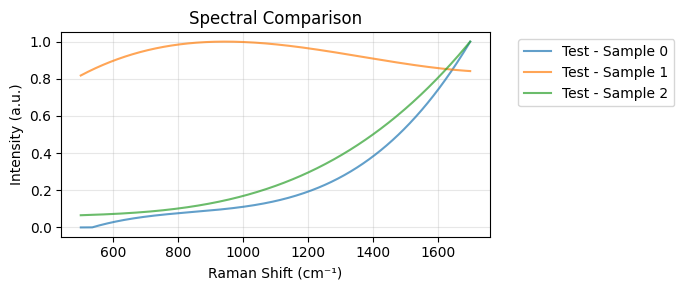

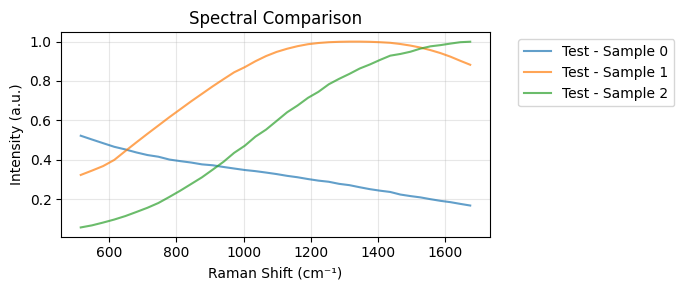

In [20]:
pu.compare_spectra(
    [pu.convert_to_spectral_data(synthetic_ds, intensity_var="fluorophore_bases_gt")],
    titles=["Test"],
    n_samples=3,
    height=3,
    width=7,
)

pu.compare_spectra(
    [pu.convert_to_spectral_data(fluorophore_ds, intensity_var="intensity")],
    titles=["Test"],
    n_samples=3,
    height=3,
    width=7,
)

In [22]:
# # Extract normalized intensity data
# X_0pt1s = very_low_snr['intensity_normalised'].values
# X_1s = low_snr['intensity_normalised'].values  # (n_samples, n_wavenumbers)
# X_10s = high_snr['intensity_normalised'].values

# Create species labels (map species names to integers)
species_names = synthetic_ds["species"].values
unique_species = np.unique(species_names)
species_to_int = {name: i for i, name in enumerate(unique_species)}
y = np.array([species_to_int[name] for name in species_names])

print(f"Data shapes: {synthetic_ds.dims}")
print(f"Number of classes: {len(unique_species)}")
print(f"Species mapping:")
for species, idx in species_to_int.items():
    count = (y == idx).sum()
    print(f"  {idx}: {species} ({count} samples)")

Data shapes: FrozenMappingWarningOnValuesAccess({'sample': 1000, 'bleaching_time': 101, 'wavenumber': 630, 'fluorophore': 3})
Number of classes: 7
Species mapping:
  0: Acinetobacter baumannii (143 samples)
  1: Enterococcus faecalis (135 samples)
  2: Escherichia coli (260 samples)
  3: Klebsiella Pneumoniae (70 samples)
  4: Pseudomonas aeruginosa (131 samples)
  5: Staphylococcus aureus (189 samples)
  6: Staphylococcus epidermidis (72 samples)


## Fluorescence Plotting Functions

(<Figure size 3000x1000 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

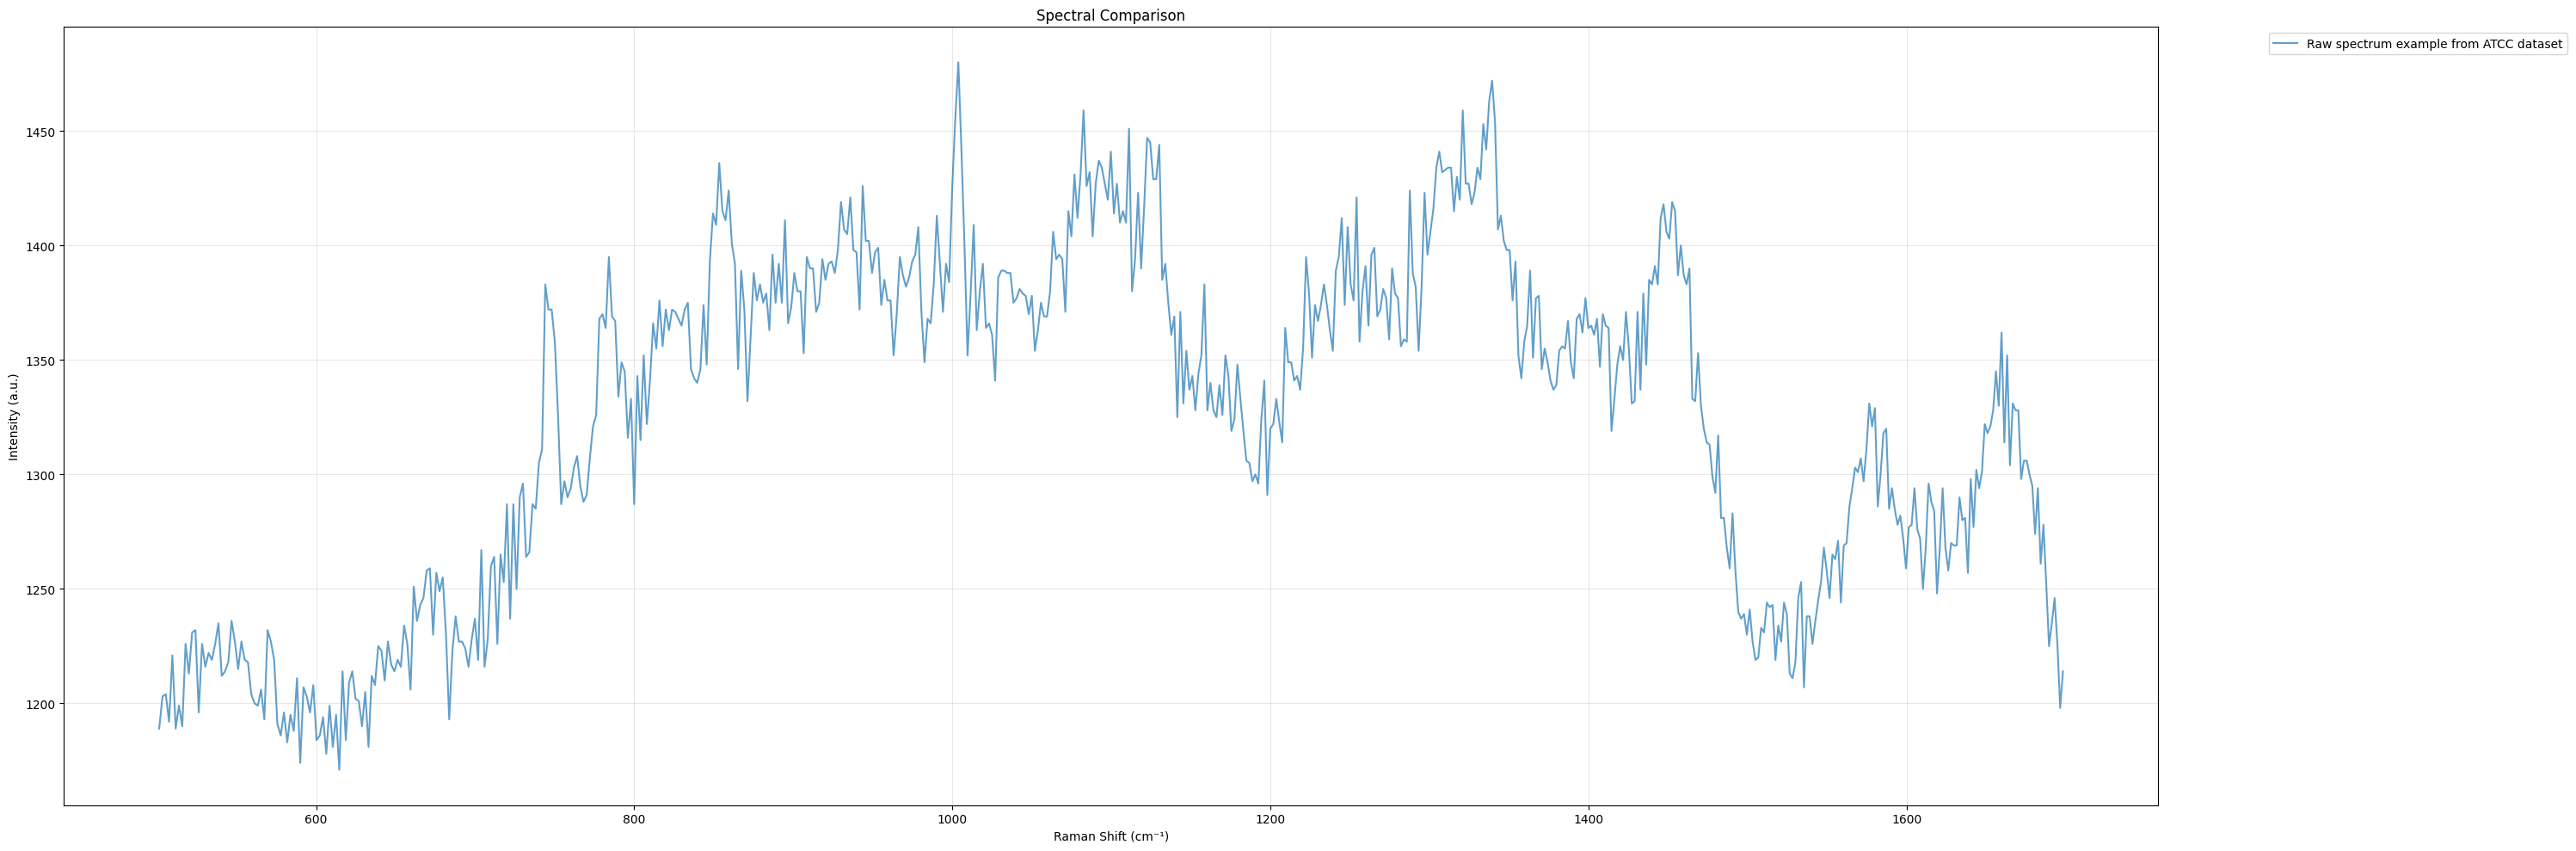

In [16]:

# Extract intensity and wavenumber arrays for a single sample at 15s integration time
intensity = atcc_xr.sel(integration_time='15s')
wavenumber = atcc_xr.sel(integration_time='15s')



# Visualize the raw spectrum using the provided plotting utility
compare_spectra(
    [pu.convert_to_spectral_data(intensity)],
    titles=['Raw spectrum example from ATCC dataset'],
    n_samples=1,
    height=10
)

In [30]:
print(atcc_xr['intensity_raw'].sel(integration_time='15s').isel(sample=0).values)

[1181. 1176. 1154. 1167. 1179. 1175. 1172. 1178. 1188. 1165. 1167. 1174.
 1191. 1171. 1188. 1170. 1171. 1181. 1180. 1173. 1168. 1179. 1156. 1173.
 1180. 1171. 1162. 1168. 1170. 1175. 1168. 1154. 1157. 1152. 1165. 1161.
 1179. 1188. 1174. 1197. 1179. 1188. 1201. 1212. 1177. 1211. 1181. 1195.
 1189. 1203. 1204. 1192. 1221. 1189. 1199. 1190. 1226. 1213. 1231. 1232.
 1196. 1226. 1216. 1222. 1219. 1226. 1235. 1212. 1214. 1218. 1236. 1227.
 1215. 1227. 1219. 1218. 1204. 1200. 1199. 1206. 1193. 1232. 1227. 1219.
 1191. 1186. 1196. 1183. 1195. 1188. 1211. 1174. 1207. 1203. 1196. 1208.
 1184. 1186. 1194. 1178. 1199. 1181. 1195. 1171. 1214. 1184. 1209. 1214.
 1202. 1201. 1190. 1205. 1181. 1212. 1208. 1225. 1223. 1210. 1227. 1217.
 1214. 1219. 1216. 1234. 1226. 1206. 1251. 1236. 1243. 1246. 1258. 1259.
 1230. 1257. 1249. 1255. 1230. 1193. 1223. 1238. 1227. 1227. 1224. 1216.
 1228. 1237. 1219. 1267. 1216. 1228. 1260. 1264. 1226. 1265. 1253. 1287.
 1237. 1287. 1250. 1290. 1296. 1264. 1266. 1287. 12

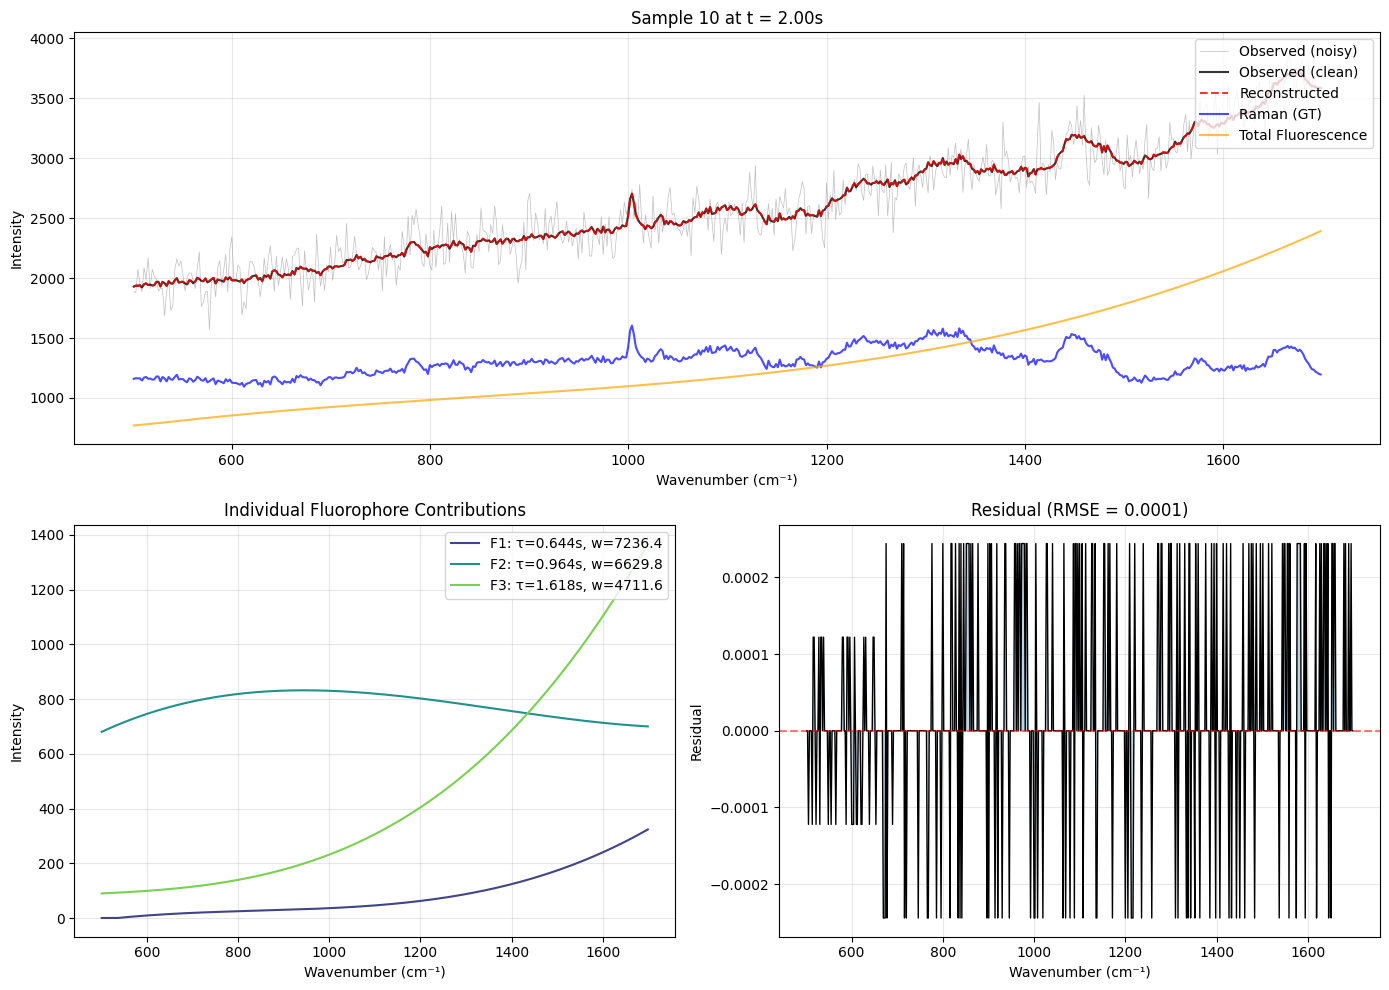

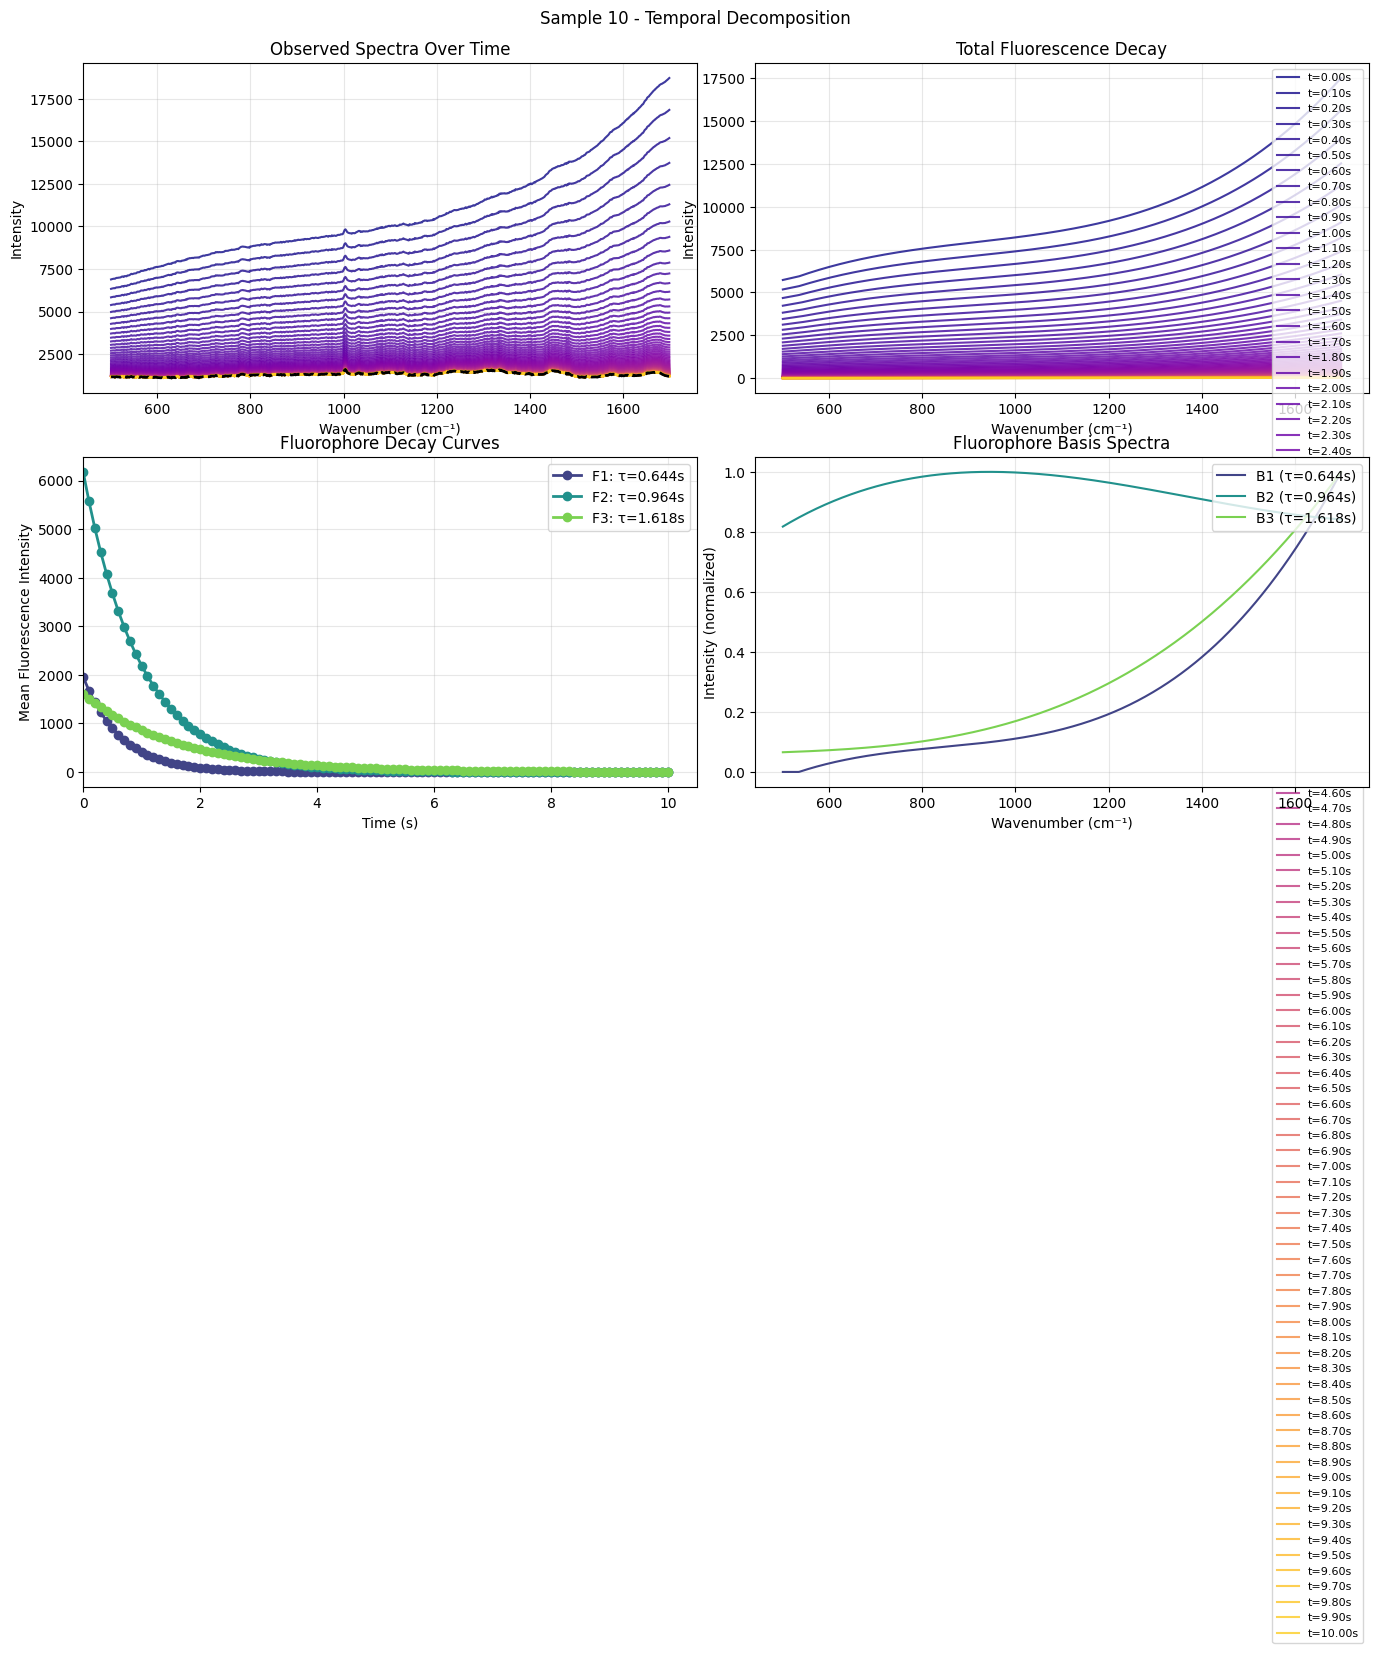

In [22]:
# Import the corrected visualization utilities
import sys
sys.path.append(".")  # Add current directory to path
from visualization_utils import (
    plot_decomposition,
    plot_stacked_decomposition,
    plot_temporal_decomposition,

)
sample_idx = 10


fig = plot_decomposition(synthetic_ds, sample_idx=sample_idx, time_seconds=2.0)
plt.show()

fig = plot_temporal_decomposition(synthetic_ds, sample_idx=sample_idx)
plt.show()

# fig = plot_stacked_decomposition(synthetic_ds, sample_idx=sample_idx, time_seconds=0.1)
# plt.show()

from visualization_utils import visualise_decomposition_3d

# Create figure
fig = visualise_decomposition_3d(synthetic_ds, sample_idx=1)

# Display interactively in notebook
fig.show()



In [49]:
# Check the actual wavenumber ranges
print("Fluorophore dataset:")
print(f"  Wavenumber range: {fluorophore_ds['wavenumber'].min().values:.2f} - {fluorophore_ds['wavenumber'].max().values:.2f} cm⁻¹")
print(f"  Shape: {fluorophore_ds['wavenumber'].shape}")
print()

# Check if fluorophores have zeros at edges BEFORE variation is added
sample_idx = 0
fluor_spectrum = fluorophore_ds['intensity'].isel(sample=sample_idx).values
print(f"Sample fluorophore (index {sample_idx}):")
print(f"  First 5 values: {fluor_spectrum[:5]}")
print(f"  Last 5 values: {fluor_spectrum[-5:]}")
print(f"  Min value: {fluor_spectrum.min():.6f}")
print(f"  Max value: {fluor_spectrum.max():.6f}")


Fluorophore dataset:
  Wavenumber range: 515.46 - 1673.70 cm⁻¹
  Shape: (38,)

Sample fluorophore (index 0):
  First 5 values: [0.5219     0.50269997 0.484      0.46560001 0.4522    ]
  Last 5 values: [0.19949999 0.1911     0.18440001 0.17560001 0.1673    ]
  Min value: 0.167300
  Max value: 0.521900


## Exponential Fitting Threshold

In [ ]:
# # Cell: Fluorescence Decay Analysis

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit, differential_evolution
# from scipy.signal import savgol_filter
# from typing import Tuple, List, Optional

# # Define exponential models
# def single_exp(t, A, tau, offset):
#     """Single exponential decay with offset."""
#     return A * np.exp(-t / tau) + offset

# def double_exp(t, A1, tau1, A2, tau2, offset):
#     """Sum of two exponentials with offset."""
#     return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + offset

# def triple_exp(t, A1, tau1, A2, tau2, A3, tau3, offset):
#     """Sum of three exponentials with offset."""
#     return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + A3 * np.exp(-t / tau3) + offset

# def fit_exponential_mixture(
#     time_axis: np.ndarray,
#     use_samples: Optional[int],
#     signal: np.ndarray,
#     n_components: int = 3,
#     initial_guess: Optional[List[float]] = None
# ) -> Tuple[np.ndarray, np.ndarray, dict]:
#     """
#     Fit a mixture of exponentials to decay data.
    
#     Args:
#         time_axis: Time points (seconds)
#         signal: Signal intensity at each time point
#         n_components: Number of exponential components (1, 2, or 3)
#         initial_guess: Initial parameter estimates
#         use_samples: Number of samples to use from the start of the signal for fitting
#     Returns:
#         popt: Optimal parameters
#         pcov: Covariance matrix
#         info: Dictionary with component breakdown
#     """
#     if n_components == 1:
#         func = single_exp
#         if initial_guess is None:
#             initial_guess = [signal.max() - signal.min(), 1.0, signal.min()]
#         bounds = ([0, 1e-6, -np.inf], [np.inf, 100, np.inf])
#     elif n_components == 2:
#         func = double_exp
#         if initial_guess is None:
#             amp = (signal.max() - signal.min()) / 2
#             initial_guess = [amp, 0.1, amp, 1.0, signal.min()]
#         bounds = ([0, 1e-6, 0, 1e-6, -np.inf], [np.inf, 100, np.inf, 100, np.inf])
#     else:
#         func = triple_exp
#         if initial_guess is None:
#             amp = (signal.max() - signal.min()) / 3
#             initial_guess = [amp, 0.01, amp, 0.3, amp, 3.0, signal.min()]
#         bounds = ([0, 1e-6, 0, 1e-6, 0, 1e-6, -np.inf], 
#                   [np.inf, 100, np.inf, 100, np.inf, 100, np.inf])
    
#     try:
#         popt, pcov = curve_fit(
#             func, time_axis[:use_samples] if use_samples else time_axis, signal[:use_samples] if use_samples else signal, 
#             p0=initial_guess, 
#             bounds=bounds,
#             maxfev=10000
#         )
        
#         # Compute fit quality
#         fitted = func(time_axis, *popt)
#         residuals = signal - fitted
#         ss_res = np.sum(residuals**2)
#         ss_tot = np.sum((signal - signal.mean())**2) # measures variation?
#         r_squared = 1 - (ss_res / ss_tot)
        
#         # Build component info
#         info = {
#             'r_squared': r_squared,
#             'residual_std': np.std(residuals),
#             'n_components': n_components,
#             'function': func
#         }
        
#         if n_components >= 1:
#             info['tau1'] = popt[1]
#             info['A1'] = popt[0]
#             info['halflife1'] = popt[1] * np.log(2)
#         if n_components >= 2:
#             info['tau2'] = popt[3]
#             info['A2'] = popt[2]
#             info['halflife2'] = popt[3] * np.log(2)
#         if n_components >= 3:
#             info['tau3'] = popt[5]
#             info['A3'] = popt[4]
#             info['halflife3'] = popt[5] * np.log(2)
#         info['offset'] = popt[-1]
        
#         return popt, pcov, info
        
#     except RuntimeError as e:
#         print(f"Fitting failed: {e}")
#         return None, None, {'error': str(e)}



In [34]:
synthetic_ds

<xarray.Dataset> Size: 514MB
Dimensions:                 (sample: 1000, bleaching_time: 101,
                             wavenumber: 630, fluorophore: 3)
Coordinates:
  * sample                  (sample) int64 8kB 0 1 2 3 4 ... 995 996 997 998 999
  * bleaching_time          (bleaching_time) <U4 2kB '0s' '0.1s' ... '10s'
    wavenumber              (sample, wavenumber) float32 3MB 501.3 ... 1.698e+03
    bleaching_time_seconds  (bleaching_time) float64 808B 0.0 0.1 ... 9.9 10.0
Dimensions without coordinates: fluorophore
Data variables:
    intensity_raw           (sample, bleaching_time, wavenumber) float32 255MB ...
    intensity_clean         (sample, bleaching_time, wavenumber) float32 255MB ...
    raman_gt                (sample, wavenumber) float32 3MB 1.597e+03 ... 1....
    decay_rates_gt          (sample, fluorophore) float32 12kB 0.8686 ... 0.4289
    abundances_gt           (sample, fluorophore) float32 12kB 1.382e+04 ... ...
    species                 (sample) <U26 104kB 'Pseudomonas aeruginosa' ... ...
    fluorophore_bases_gt    (fluorophore, wavenumber) float64 15kB 0.05302 .....
Attributes:
    title:                 Synthetic Photobleaching Dataset
    n_samples:             1000
    n_fluorophores:        3
    shared_bases:          True
    noise_type:            poisson_gaussian
    poisson_noise_scale:   2
    gaussian_noise_scale:  0.1
    fr_ratio_range:        5.0-12.0
    decay_rate_range:      0.3-1 s⁻¹
    seed:                  None

In [16]:
synthetic_ds

<xarray.Dataset> Size: 514MB
Dimensions:               (sample: 1000, bleaching_time: 101, wavenumber: 630,
                           fluorophore: 3)
Coordinates:
  * sample                (sample) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * bleaching_time        (bleaching_time) float64 808B 0.0 0.1 0.2 ... 9.9 10.0
    wavenumber            (sample, wavenumber) float32 3MB 501.2 ... 1.698e+03
Dimensions without coordinates: fluorophore
Data variables:
    intensity_raw         (sample, bleaching_time, wavenumber) float32 255MB ...
    intensity_clean       (sample, bleaching_time, wavenumber) float32 255MB ...
    raman_gt              (sample, wavenumber) float32 3MB 1.063e+03 ... 1.33...
    decay_rates_gt        (sample, fluorophore) float32 12kB 0.7253 ... 0.4416
    abundances_gt         (sample, fluorophore) float32 12kB 3.806e+06 ... 3....
    species               (sample) <U26 104kB 'Enterococcus faecalis' ... 'Ac...
    fluorophore_bases_gt  (fluorophore, wavenumber) float64 15kB 0.001797 ......
Attributes:
    title:                 Synthetic Photobleaching Dataset
    n_samples:             1000
    n_fluorophores:        3
    shared_bases:          True
    noise_type:            poisson_gaussian
    poisson_noise_scale:   2
    gaussian_noise_scale:  0.1
    fr_ratio_range:        5.0-12.0
    decay_rate_range:      0.3-1 s⁻¹
    seed:                  None

In [39]:
synthetic_ds

<xarray.Dataset> Size: 514MB
Dimensions:               (sample: 1000, bleaching_time: 101, wavenumber: 630,
                           fluorophore: 3)
Coordinates:
  * sample                (sample) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * bleaching_time        (bleaching_time) float64 808B 0.0 0.1 0.2 ... 9.9 10.0
    wavenumber            (sample, wavenumber) float32 3MB 501.2 ... 1.698e+03
Dimensions without coordinates: fluorophore
Data variables:
    intensity_raw         (sample, bleaching_time, wavenumber) float32 255MB ...
    intensity_clean       (sample, bleaching_time, wavenumber) float32 255MB ...
    raman_gt              (sample, wavenumber) float32 3MB 1.063e+03 ... 1.33...
    decay_rates_gt        (sample, fluorophore) float32 12kB 0.7253 ... 0.4416
    abundances_gt         (sample, fluorophore) float32 12kB 3.806e+06 ... 3....
    species               (sample) <U26 104kB 'Enterococcus faecalis' ... 'Ac...
    fluorophore_bases_gt  (fluorophore, wavenumber) float64 15kB 0.001797 ......
Attributes:
    title:                 Synthetic Photobleaching Dataset
    n_samples:             1000
    n_fluorophores:        3
    shared_bases:          True
    noise_type:            poisson_gaussian
    poisson_noise_scale:   2
    gaussian_noise_scale:  0.1
    fr_ratio_range:        5.0-12.0
    decay_rate_range:      0.3-1 s⁻¹
    seed:                  None

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]


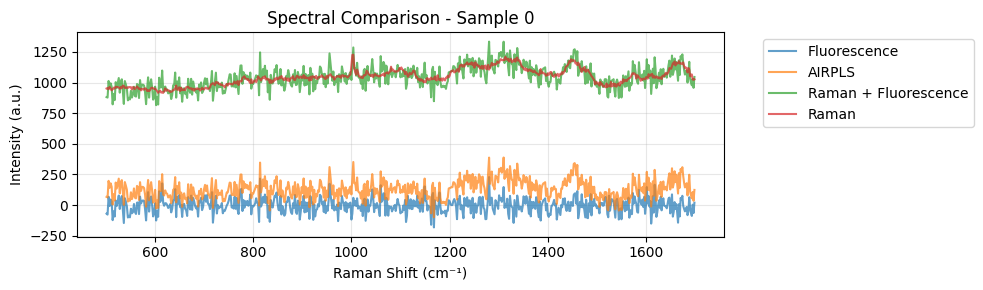

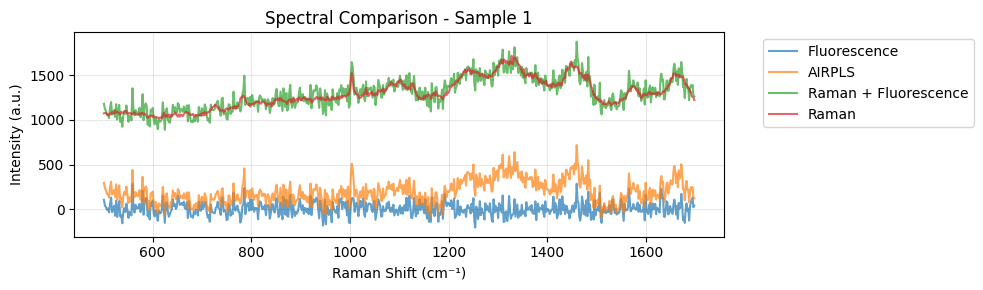

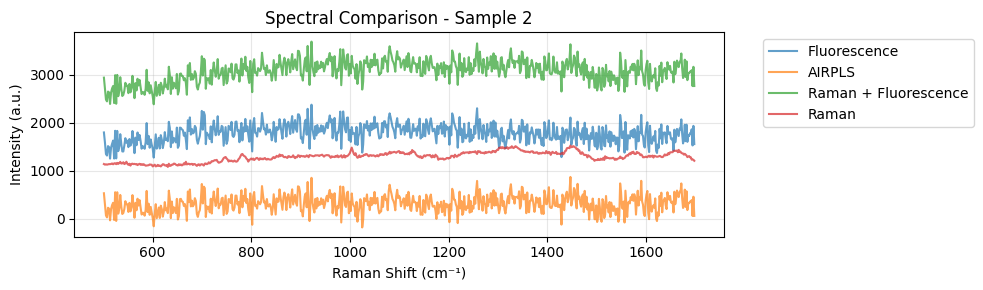

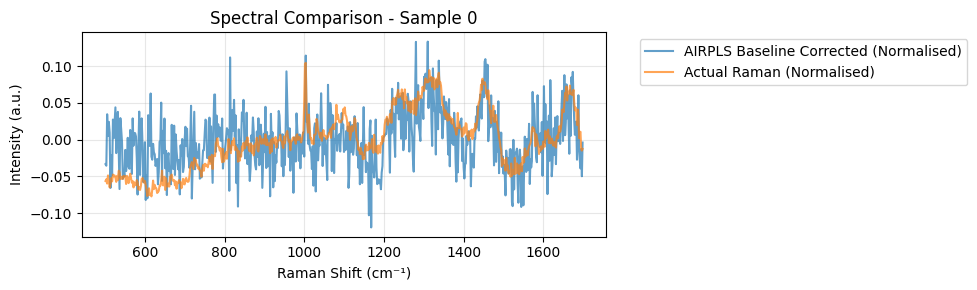

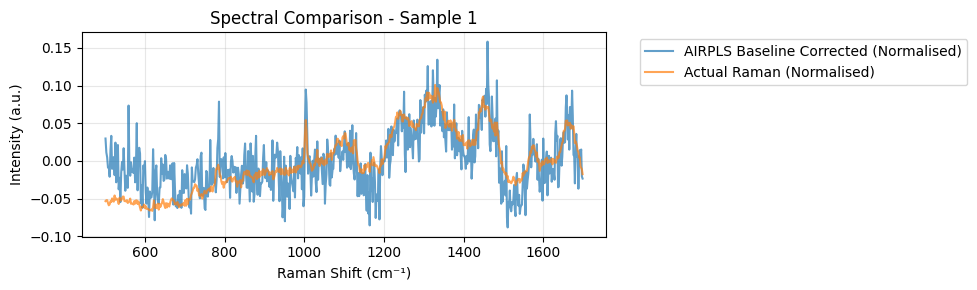

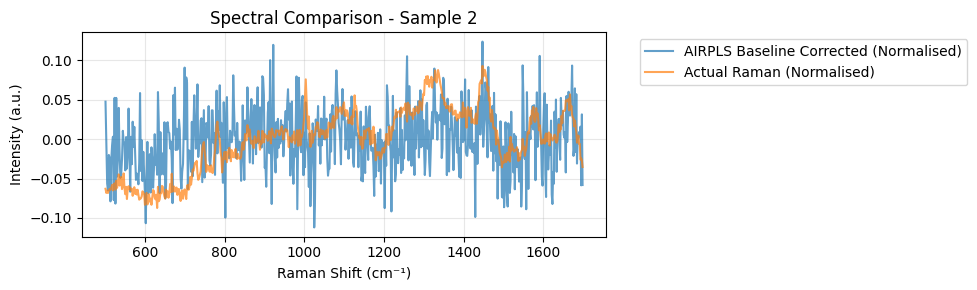

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison - Sample 2'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

In [23]:
import ramanspy as rp

print(synthetic_ds.bleaching_time.values)
time_point = 10.0
raman = pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=0.1), intensity_var='raman_gt')
fluorescence = (synthetic_ds.intensity_raw - synthetic_ds.raman_gt).sel(bleaching_time=time_point)


compare_spectra(
    [pu.convert_to_spectral_data(fluorescence),  pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw').apply_ramanspy_preprocessing(rp.preprocessing.baseline.AIRPLS()), pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw'), raman],
    titles=["Fluorescence","AIRPLS", "Raman + Fluorescence", "Raman"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

# Convert AIRPLS-processed and actual Raman to SpectralData, then normalise both for direct comparison
airpls_data = pu.convert_to_spectral_data(
    synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw'
).apply_ramanspy_preprocessing(rp.preprocessing.baseline.AIRPLS())

# Normalise both spectra to unit norm for shape comparison
airpls_data_normalised = airpls_data.normalize_for_plotting(method='l2')
raman_normalised = raman.normalize_for_plotting(method='l2')

compare_spectra(
    [airpls_data_normalised, raman_normalised],
    titles=["AIRPLS Baseline Corrected (Normalised)", "Actual Raman (Normalised)"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

Testing 10 configurations on 30 samples

5 pts: 1-exp 2-exp 3-exp 
15 pts: 1-exp 2-exp 3-exp 
25 pts: 1-exp 2-exp 3-exp 
35 pts: 1-exp 2-exp 3-exp 
45 pts: 1-exp 2-exp 3-exp 
55 pts: 1-exp 2-exp 3-exp 
65 pts: 1-exp 2-exp 3-exp 
75 pts: 1-exp 2-exp 3-exp 
85 pts: 1-exp 2-exp 3-exp 
95 pts: 1-exp 2-exp 3-exp SUMMARY

1-Component Model:
------------------------------------------------------------
Points     R² (full)       RMSE            Success   
------------------------------------------------------------
5          0.7720         355.4605        100%
15         0.9251         171.9939        100%
25         0.9665         100.6274        100%
35         0.9831         67.7034         100%
45         0.9906         50.8286         100%
55         0.9941         41.8229         100%
65         0.9957         37.0556         100%
75         0.9964         34.6591         100%
85         0.9967         33.5768         100%
95         0.9969         33.1935         100%

2-Component Mode

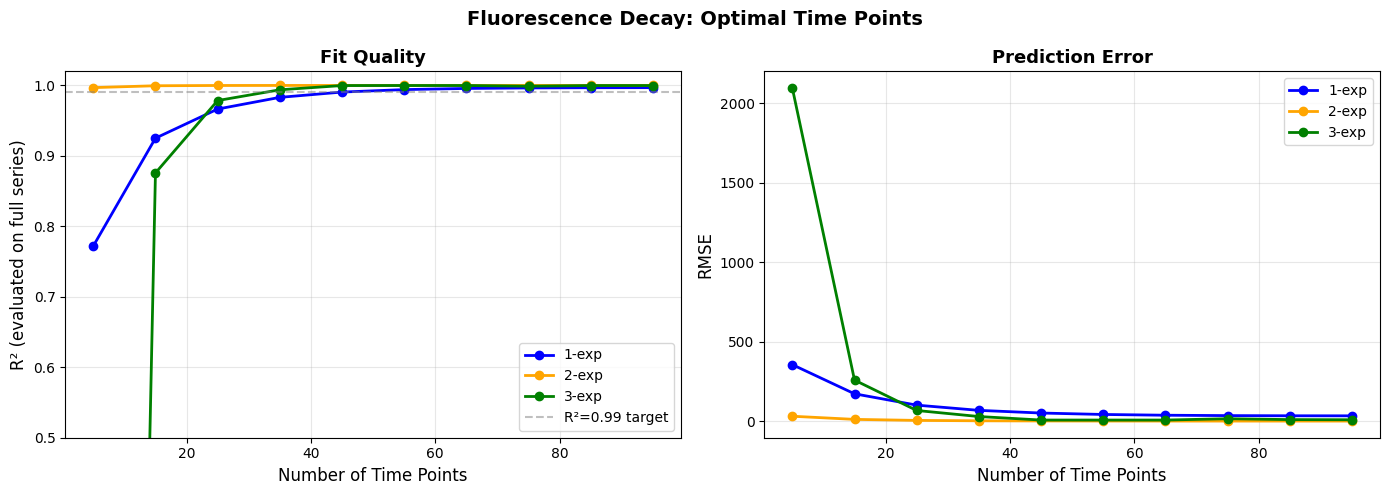


1-component: 45 points (55% reduction)
  → R² = 0.9906, RMSE = 50.8286

2-component: 5 points (95% reduction)
  → R² = 0.9969, RMSE = 30.7083

3-component: 35 points (65% reduction)
  → R² = 0.9938, RMSE = 28.8368


In [12]:
import numpy as np
import xarray as xr
from typing import Dict, Any, List, Tuple, Optional
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import OptimizeWarning

# Suppress curve_fit warnings
warnings.filterwarnings('ignore', category=OptimizeWarning)

# Define exponential models
def single_exp(t, A, tau, offset):
    return A * np.exp(-t / tau) + offset

def double_exp(t, A1, tau1, A2, tau2, offset):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + offset

def triple_exp(t, A1, tau1, A2, tau2, A3, tau3, offset):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + A3 * np.exp(-t / tau3) + offset

def fit_exponential_mixture(
    time_axis: np.ndarray,
    signal: np.ndarray,
    n_components: int = 2,
    maxfev: int = 5000
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Fit exponential mixture, return parameters and info dict with R^2 and RMSE."""
    if n_components == 1:
        func = single_exp
        initial_guess = [signal.max() - signal.min(), 1.0, signal.min()]
        bounds = ([0, 1e-6, -np.inf], [np.inf, 100, np.inf])
    elif n_components == 2:
        func = double_exp
        amp = (signal.max() - signal.min()) / 2
        initial_guess = [amp, 0.1, amp, 1.0, signal.min()]
        bounds = ([0, 1e-6, 0, 1e-6, -np.inf], [np.inf, 100, np.inf, 100, np.inf])
    else:
        func = triple_exp
        amp = (signal.max() - signal.min()) / 3
        initial_guess = [amp, 0.01, amp, 0.3, amp, 3.0, signal.min()]
        bounds = ([0, 1e-6, 0, 1e-6, 0, 1e-6, -np.inf], 
                  [np.inf, 100, np.inf, 100, np.inf, 100, np.inf])
    
    try:
        popt, pcov = curve_fit(func, time_axis, signal, p0=initial_guess, bounds=bounds, maxfev=maxfev)
        fitted = func(time_axis, *popt)
        residuals = signal - fitted
        r_squared = 1 - (np.sum(residuals**2) / np.sum((signal - signal.mean())**2))
        info = {
            'r_squared': r_squared,
            'rmse': np.sqrt(np.mean(residuals ** 2)),
            'function': func
        }
        return popt, pcov, info
    except Exception as e:
        return None, None, {'error': str(e)}


def find_optimal_timepoints(
    ds: xr.Dataset,
    n_test_samples: int = 30,
    min_points: int = 5,
    max_points: int = None,
    step: int = 10,
    seed: int = 42,
    test_n_components: List[int] = [1, 2, 3]
) -> Dict[str, Any]:
    """Find optimal number of time points for fluorescence decay modeling."""
    np.random.seed(seed)
    
    time = ds.bleaching_time.values
    # Extract pure fluorescence (subtract constant Raman signal)
    fluorescence = ds.intensity_clean- ds.raman_gt
    mean_decay = fluorescence.mean(dim="wavenumber")
    
    if max_points is None:
        max_points = len(time)
    
    n_samples = min(n_test_samples, mean_decay.shape[0])
    sample_indices = np.random.choice(mean_decay.shape[0], n_samples, replace=False)
    n_points_range = np.arange(min_points, max_points + 1, step)
    
   
    all_results = {}
    for n_comp in test_n_components:
        all_results[n_comp] = {
            'n_points': [],
            'r_squared_mean': [],
            'rmse_mean': [],
            'fit_success_rate': []
        }
    
    print(f"Testing {len(n_points_range)} configurations on {n_samples} samples")
    
    for n_pts in n_points_range:
        print(f"\n{n_pts} pts:", end=" ", flush=True)
        
        for n_comp in test_n_components:
            print(f"{n_comp}-exp", end=" ", flush=True)
            
            r2_list = []
            rmse_list = []
            success_count = 0
            
            for sample_idx in sample_indices:
                y_full = mean_decay.isel(sample=sample_idx).values
                t_subset = time[:n_pts]
                y_subset = y_full[:n_pts]
                
                popt, pcov, info = fit_exponential_mixture(t_subset, y_subset, n_components=n_comp)
                
                if popt is not None:
                    # Evaluate on FULL time series
                    y_pred_full = info['function'](time, *popt)
                    residuals_full = y_full - y_pred_full
                    r2_full = 1 - (np.sum(residuals_full ** 2) / np.sum((y_full - y_full.mean()) ** 2))
                    rmse_full = np.sqrt(np.mean(residuals_full ** 2))
                    
                    r2_list.append(r2_full)
                    rmse_list.append(rmse_full)
                    success_count += 1
            
            results = all_results[n_comp]
            results['n_points'].append(n_pts)
            results['r_squared_mean'].append(np.mean(r2_list) if r2_list else np.nan)
            results['rmse_mean'].append(np.mean(rmse_list) if rmse_list else np.nan)
            results['fit_success_rate'].append(success_count / n_samples)
    
    print("SUMMARY")
    for n_comp in test_n_components:
        results = all_results[n_comp]
        print(f"\n{n_comp}-Component Model:")
        print("-"*60)
        print(f"{'Points':<10} {'R² (full)':<15} {'RMSE':<15} {'Success':<10}")
        print("-"*60)
        for i in range(len(results['n_points'])):
            print(f"{results['n_points'][i]:<10} "
                  f"{results['r_squared_mean'][i]:.4f}         "
                  f"{results['rmse_mean'][i]:<15.4f} "
                  f"{results['fit_success_rate'][i]*100:.0f}%")
    print("="*60)
    
    return all_results


# Run analysis
ds = synthetic_ds
all_results = find_optimal_timepoints(ds, n_test_samples=30, step=10, test_n_components=[1, 2, 3])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {1: 'blue', 2: 'orange', 3: 'green'}
labels = {1: '1-exp', 2: '2-exp', 3: '3-exp'}

# R^2 plot
ax = axes[0]
for n_comp, results in all_results.items():
    r2 = np.array(results['r_squared_mean'])
    ax.plot(results['n_points'], r2, marker='o', label=labels[n_comp],
            color=colors[n_comp], linewidth=2, markersize=6)
ax.axhline(0.99, color='gray', linestyle='--', alpha=0.5, label='R²=0.99 target')
ax.set_xlabel('Number of Time Points', fontsize=12)
ax.set_ylabel('R² (evaluated on full series)', fontsize=12)
ax.set_title('Fit Quality', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.02])

# RMSE plot
ax = axes[1]
for n_comp, results in all_results.items():
    rmse = np.array(results['rmse_mean'])
    ax.plot(results['n_points'], rmse, marker='o', 
            label=labels[n_comp], color=colors[n_comp], linewidth=2, markersize=6)
ax.set_xlabel('Number of Time Points', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Prediction Error', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Fluorescence Decay: Optimal Time Points', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

for n_comp in [1, 2, 3]:
    results = all_results[n_comp]
    r2_arr = np.array(results['r_squared_mean'])
    rmse_arr = np.array(results['rmse_mean'])
    
    good_idx = np.where(r2_arr > 0.99)[0]
    if len(good_idx) > 0:
        idx = good_idx[0]
        n_pts = results['n_points'][idx]
        total_pts = len(synthetic_ds.bleaching_time)
        reduction = (1 - n_pts/total_pts) * 100
        
        print(f"\n{n_comp}-component: {n_pts} points ({reduction:.0f}% reduction)")
        print(f"  → R² = {r2_arr[idx]:.4f}, RMSE = {rmse_arr[idx]:.4f}")
    else:
        print(f"\n{n_comp}-component: Needs all points (R² < 0.99)")


In [13]:

import importlib
import decomposition
importlib.reload(decomposition)
from decomposition import fit_physics_model, visualise_decomposition

time_series = synthetic_ds.sel(sample=0).intensity_clean.values  # (n_timepoints, n_wavenumbers)
wavenumbers_arr = synthetic_ds.sel(sample=0).wavenumber.values
n_measurements = time_series.shape[0]
acquisition_time = 0.1
time_values = synthetic_ds.bleaching_time.values  # (n_timepoints,)
print(f"Time series shape: {time_series.shape}, Wavenumbers: {wavenumbers_arr.shape}, Time values: {time_values.shape}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, history = fit_physics_model(
    data=time_series,
    time_values=time_values,
    wavenumber_axis=wavenumbers_arr,

    n_epochs=50000,
    lr=0.005,
    n_fluorophores=3,              
    basis_type='polynomial',
    polynomial_degree=3,               
    min_decay_rate=0.1,          
    first_times=20,
    device=device
)

Time series shape: (101, 630), Wavenumbers: (630,), Time values: (101,)
Initialized decay rates τ: [0.9439105 0.9171274 1.0771202]
Epoch 1000/50000:
  loss: 283248.156250
  mse: 283248.156250
  intensity_ratio: 0.000000
  mse_validation: 283248.156250
  Current τ: [0.72243446 0.6454223  1.1896317 ]
  Current A: [364.6739  371.2759  340.44794]
Epoch 2000/50000:
  loss: 35832.890625
  mse: 35832.890625
  intensity_ratio: 0.000000
  mse_validation: 35832.890625
  Current τ: [0.43556437 0.23065904 2.111395  ]
  Current A: [374.3151  436.59967 417.87683]
Epoch 3000/50000:
  loss: 16171.635742
  mse: 16171.635742
  intensity_ratio: 0.000000
  mse_validation: 16171.635742
  Current τ: [0.43560162 0.19992815 1.644017  ]
  Current A: [336.00348 449.06012 458.41165]
Epoch 4000/50000:
  loss: 4983.206543
  mse: 4983.206543
  intensity_ratio: 0.000000
  mse_validation: 4983.206543
  Current τ: [0.39602733 0.2233733  1.4167017 ]
  Current A: [294.531   494.60205 466.6141 ]
Epoch 5000/50000:
  loss:

Actual bases shape: (3, 630)


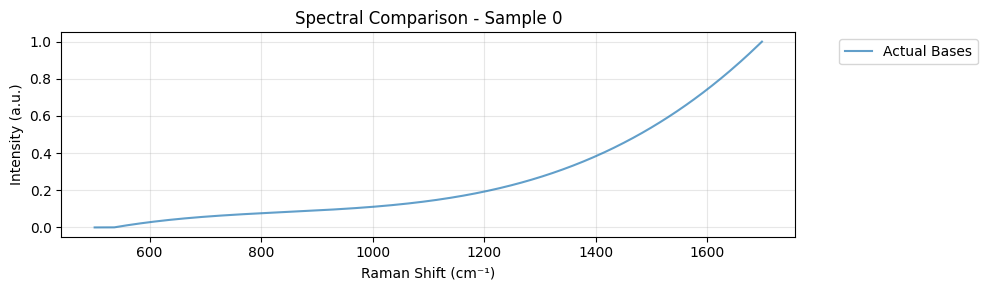

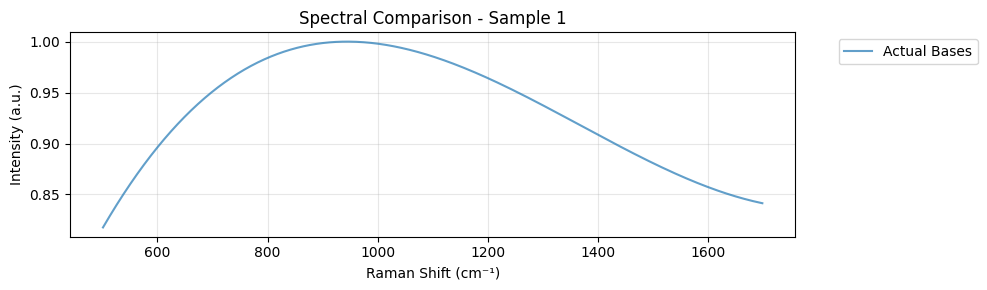

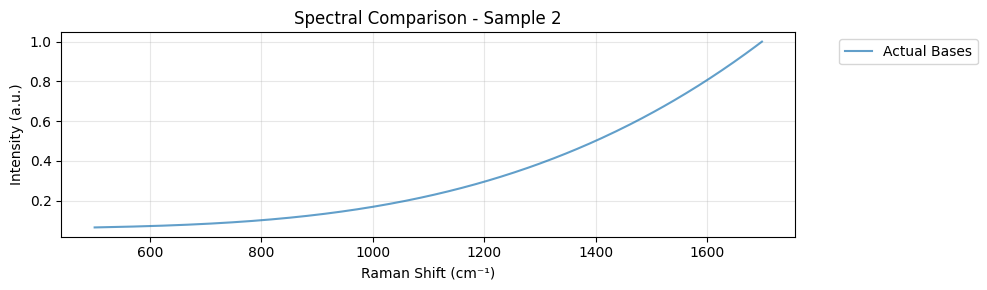

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison - Sample 2'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

In [38]:
actual_bases = synthetic_ds.isel(sample=0).fluorophore_bases_gt.values
print("Actual bases shape:", actual_bases.shape)

#plot actual bases 
compare_spectra(
    [pu.convert_to_spectral_data(actual_bases, wavenumbers=synthetic_ds.wavenumber.values)],
    titles=["Actual Bases"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

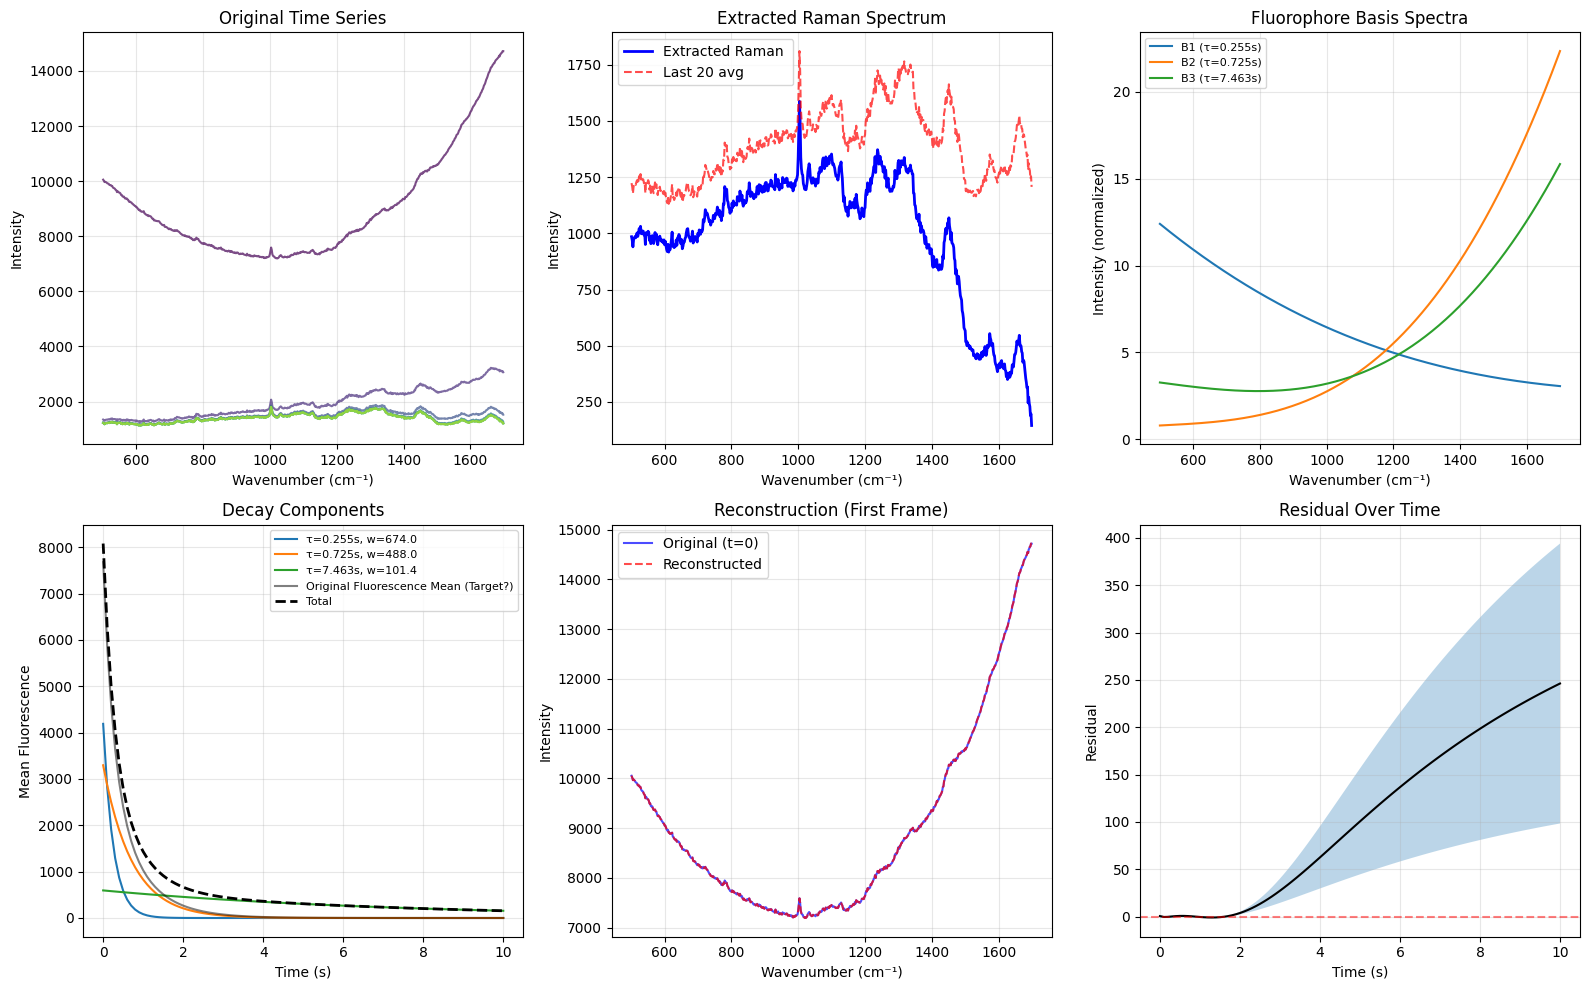


Reconstruction MSE: 24528.066406, R²: 0.985250
Time constants (τ): [0.25479466 0.7248039  7.4629827 ]
Abundances (w): [673.97473 487.98154 101.39525]


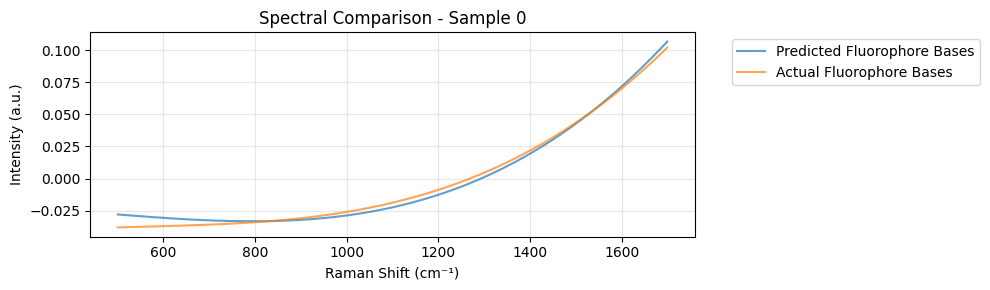

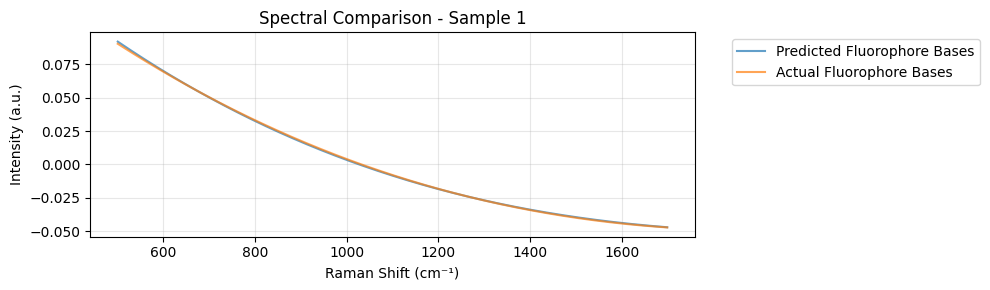

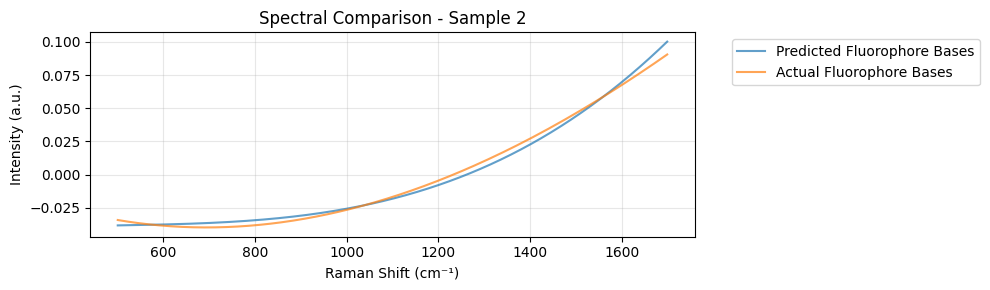

In [14]:
# Visualise results
visualise_decomposition(
    model=model,
    original_data=time_series,
    wavenumbers=wavenumbers_arr,
    time_values=time_values
)


# from decomposition import visualise_decomposition_3d
# visualise_decomposition_3d(model, time_series, wavenumbers_arr, time_values)




# compare predicted vs actual fluorophore spectra
predicted_bases = model.fluorophore_bases.cpu().detach().numpy()  # (n_fluorophores, n_wavenumbers)
actual_bases = synthetic_ds.isel(sample=0).fluorophore_bases_gt.values  # (n_fluorophores, n_wavenumbers)
pu.compare_spectra(
    [pu.convert_to_spectral_data(predicted_bases, wavenumbers=wavenumbers_arr).normalize_for_plotting(method='l2'),
     pu.convert_to_spectral_data(actual_bases, wavenumbers=wavenumbers_arr).normalize_for_plotting(method='l2')],
    titles=["Predicted Fluorophore Bases", "Actual Fluorophore Bases"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

actual_bases = synthetic_ds.isel(sample=0).fluorophore_bases_gt.values

from decomposition import visualise_decomposition_3d
visualise_decomposition_3d(model, time_series, wavenumbers_arr, time_values)